# RBM training $ L=100$  - Dataset with 25 different temperatures - MEAN FIELD

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
import seaborn as sns

import torch
import torch.nn as nn
torch.manual_seed(12)

import sys
sys.path.append('../modules')
from rbm import RBM
from mc_ising2d_MF import IsingMC

L = 100

## Loading Ising data

The first step is to load the Ising data generated by Monte Carlo procedure. The file `L100_Ising2D_MC_MF.pkl` contains spin configurations for a square lattive $L\times L$, with $L=10$, within the mean field approximation. There are 1000 spins configurations for each of 25 different temperatures $ T/J = 10^{-6}, 0.25, 0.5, ..., 5.5, 5.75, 6 $.

In [2]:
ising_data = pd.read_pickle('../data/L100_Ising2D_MC_MF.pkl')
ising_data.head()

,energy,magn,state,temp
0,-9.211033e-07,32,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, ...",6.0
1,-1.151379e-06,40,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, ...",6.0
2,-6.908272e-07,-24,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",6.0
3,-5.756892e-07,20,"[1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, ...",6.0
4,6.908293e-07,24,"[0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, ...",6.0


In [3]:
ising_data['temp'].value_counts()

5.56    1000
1.60    1000
4.00    1000
0.50    1000
2.04    1000
3.58    1000
4.01    1000
3.36    1000
4.68    1000
4.02    1000
1.16    1000
4.90    1000
1.82    1000
0.72    1000
1.38    1000
5.78    1000
2.92    1000
5.34    1000
3.99    1000
3.14    1000
2.70    1000
4.24    1000
0.94    1000
3.80    1000
2.26    1000
2.48    1000
4.46    1000
5.12    1000
6.00    1000
Name: temp, dtype: int64

With the class `IsingMC` we can check some thermodynamics quantities.

Method fit will construct states to the following temperatures: 
[6.   5.78 5.56 5.34 5.12 4.9  4.68 4.46 4.24 4.02 4.01 4.   3.99 3.8
 3.58 3.36 3.14 2.92 2.7  2.48 2.26 2.04 1.82 1.6  1.38 1.16 0.94 0.72
 0.5 ]


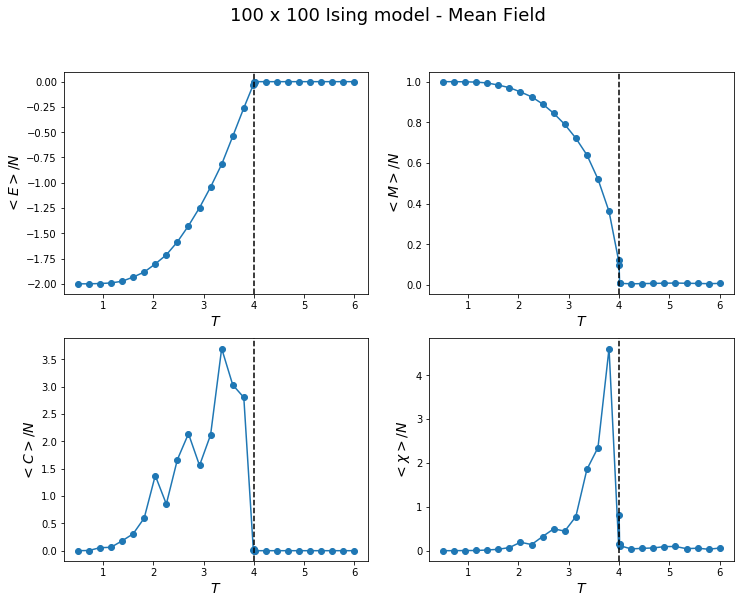

In [4]:
IsingMC(L= 100).plot_thermodynamics(spin_MC= ising_data, Tc_scaled= False)

In [5]:
data = ising_data.drop(columns= ['energy', 'magn'])

### Constructing training and test sets

Using `train_test_split` from [`sklearn`](http://scikit-learn.org/) it is easy to split the data into training and test sets. Since `train_test_split` is a random process and our data has 1000 samples for each of the 25 temperatures values, we split the data for each temperature in order to avoid the possibility of a biased split towards some temperature value.

In [6]:
train_data_ = pd.DataFrame()
test_data_ = pd.DataFrame()

for _, temp in enumerate(data['temp'].value_counts().index.tolist()):
    
    train_data_T, test_data_T = train_test_split(data[data['temp'] == temp],
                                                 test_size= 0.2,
                                                 random_state= 12)
    
    train_data_ = pd.concat([train_data_, train_data_T])
    test_data_ = pd.concat([test_data_, test_data_T])

### Training the model 

Our code implementing a Restricted Boltzmann Machine is written a python class called `RBM` which is imported from `rbm.py`.

For simplification, the units have no bias and the RBM stochasticity parameter, represented below by $T$ is set to unity, as usual in most practical applications. Note that we set `use_cuda=True`, which makes use of [CUDA tensor types](https://pytorch.org/docs/stable/cuda.html), implementing GPU computation. If a GPU is not available, one should just set `use_cuda=False`.

RBM --- Nv= 10000, Nh= 10000, lr= 1.0E-03, k= 1, Bsize= 100, Epochs= 250, USE_CUDA= True, verbose= 1
Starting training
Ep 1, Rec er: 0.265400 (train), 0.261756 (test), Pseud_Lik: -8962.634144, Time: 47.303919, 
Ep 2, Rec er: 0.258725 (train), 0.257037 (test), Pseud_Lik: -6239.779026, Time: 47.391070, 
Ep 3, Rec er: 0.253574 (train), 0.251742 (test), Pseud_Lik: -5062.088397, Time: 47.561856, 
Ep 4, Rec er: 0.247840 (train), 0.245947 (test), Pseud_Lik: -4557.162406, Time: 47.650277, 
Ep 5, Rec er: 0.241842 (train), 0.240068 (test), Pseud_Lik: -3935.306214, Time: 47.627620, 
Ep 6, Rec er: 0.235813 (train), 0.233963 (test), Pseud_Lik: -3618.753094, Time: 47.564039, 
Ep 7, Rec er: 0.229711 (train), 0.228138 (test), Pseud_Lik: -3249.323949, Time: 47.599467, 
Ep 8, Rec er: 0.223724 (train), 0.222274 (test), Pseud_Lik: -2967.850348, Time: 47.590569, 
Ep 9, Rec er: 0.217880 (train), 0.216526 (test), Pseud_Lik: -2668.019610, Time: 47.584219, 
Ep 10, Rec er: 0.212275 (train), 0.211090 (test), Pse

Ep 89, Rec er: 0.094316 (train), 0.096843 (test), Pseud_Lik: -206.354778, Time: 47.568925, 
Ep 90, Rec er: 0.093851 (train), 0.096437 (test), Pseud_Lik: -190.588348, Time: 47.587214, 
Ep 91, Rec er: 0.093452 (train), 0.096019 (test), Pseud_Lik: -192.668520, Time: 47.550205, 
Ep 92, Rec er: 0.093058 (train), 0.095636 (test), Pseud_Lik: -193.071188, Time: 47.540964, 
Ep 93, Rec er: 0.092651 (train), 0.095173 (test), Pseud_Lik: -185.536917, Time: 47.498381, 
Ep 94, Rec er: 0.092235 (train), 0.094878 (test), Pseud_Lik: -183.088135, Time: 47.634140, 
Ep 95, Rec er: 0.091812 (train), 0.094455 (test), Pseud_Lik: -184.722626, Time: 47.592582, 
Ep 96, Rec er: 0.091449 (train), 0.094064 (test), Pseud_Lik: -179.426431, Time: 47.544617, 
Ep 97, Rec er: 0.091061 (train), 0.093664 (test), Pseud_Lik: -177.986695, Time: 47.543235, 
Ep 98, Rec er: 0.090714 (train), 0.093276 (test), Pseud_Lik: -178.598555, Time: 47.540992, 
Ep 99, Rec er: 0.090347 (train), 0.092958 (test), Pseud_Lik: -178.192508, Time: 

Ep 178, Rec er: 0.070970 (train), 0.073955 (test), Pseud_Lik: -84.980413, Time: 47.570610, 
Ep 179, Rec er: 0.070796 (train), 0.073771 (test), Pseud_Lik: -86.886748, Time: 47.599908, 
Ep 180, Rec er: 0.070675 (train), 0.073592 (test), Pseud_Lik: -85.681879, Time: 47.600906, 
Ep 181, Rec er: 0.070515 (train), 0.073431 (test), Pseud_Lik: -81.862700, Time: 47.567688, 
Ep 182, Rec er: 0.070314 (train), 0.073307 (test), Pseud_Lik: -83.262799, Time: 47.594350, 
Ep 183, Rec er: 0.070153 (train), 0.073180 (test), Pseud_Lik: -79.606504, Time: 47.492152, 
Ep 184, Rec er: 0.070009 (train), 0.072990 (test), Pseud_Lik: -84.120966, Time: 47.534873, 
Ep 185, Rec er: 0.069873 (train), 0.072853 (test), Pseud_Lik: -79.859663, Time: 47.575564, 
Ep 186, Rec er: 0.069693 (train), 0.072677 (test), Pseud_Lik: -80.574959, Time: 47.606329, 
Ep 187, Rec er: 0.069564 (train), 0.072512 (test), Pseud_Lik: -81.175950, Time: 47.600152, 
Ep 188, Rec er: 0.069393 (train), 0.072349 (test), Pseud_Lik: -81.448126, Time: 

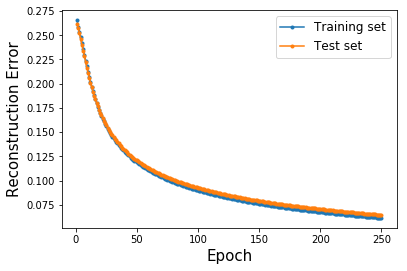

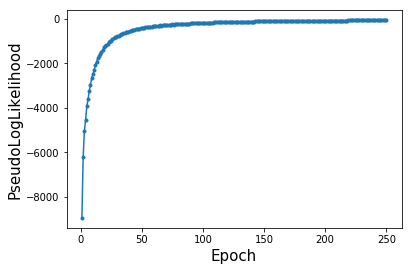

In [7]:
training_set = torch.Tensor(list(train_data_['state']))
training_set = training_set[torch.randperm(training_set.size()[0])]

test_set = torch.Tensor(list(test_data_['state']))


lr = 0.001
k_learning = 1
batch_size = 100
nb_epoch = 250
k_sampling = 1

rbm = RBM(num_visible= training_set.shape[1], 
          num_hidden= training_set.shape[1], 
          bias= False,
          T= 1.0,
          use_cuda= True)
    
rbm.learn(training_set= training_set, 
          test_set= test_set,
          lr= lr, 
          nb_epoch= nb_epoch, 
          batch_size= batch_size,
          k_learning= k_learning,
          k_sampling = k_sampling,
          verbose= 1)

### Saving the trained model

In [9]:
nb_epoch= rbm.num_train_epochs()
Nv= training_set.shape[1]
Nh= training_set.shape[1]

name = 'RBM_model_T_complete_MF_nv%d_nh%d_lr%.1E_k%d_bsize%d_nepochs%d' % (Nv,
                                                                        Nh,
                                                                        lr,
                                                                        k_learning,
                                                                        batch_size,
                                                                        nb_epoch)

PATH = '../RBM_trained_models/'+ name + '.pt'

torch.save(rbm, PATH)

### Weights distribution

In [10]:
W, v, h = rbm.parameters()

del v
del h
torch.cuda.empty_cache()

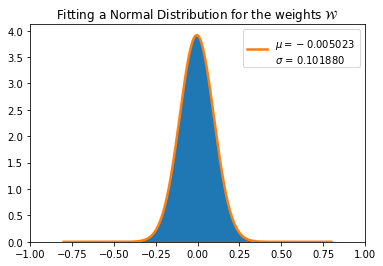

In [11]:
W_ = W.cpu().numpy().reshape((W.shape[0]*W.shape[1]))

# Plot normalized histogram 
plt.hist(W_, 
         bins= 1000, 
         density= True)

# Maximum and minimum of xticks to compute the theoretical distribution 
x_min, x_max = min(plt.xticks()[0]), max(plt.xticks()[0])  
domain = np.linspace(x_min, x_max, len(W_))

# Fitting a normal distribution
muW_, sigmaW_ = stats.norm.fit(W_) 

plot_pdf = stats.norm.pdf(domain, muW_, sigmaW_) # Fitting the PDF in the interval


plt.plot(domain, plot_pdf, linewidth= 2.5,
         label= '$\mu= %f$ \n$\sigma$ = %f' % (muW_, sigmaW_ ))

plt.title('Fitting a Normal Distribution for the weights ${\cal W}$')
plt.xlim([-1, 1])
plt.legend()
plt.show()